In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
# train.csv is a dataset between years 2011-2012
df = pd.read_csv('train.csv')

In [3]:
df = df.drop(columns=['Datetime'])

In [4]:
df

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,0.32663,81.952
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,0.44784,82.377
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,0.45144,83.776
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,0.23107,82.505
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,0.26747,82.028
...,...,...,...,...,...,...,...,...,...,...,...
15034,10.0370,1022.1,88.531,2.9192,23.641,1083.6,549.91,132.61,11.745,1.65600,76.068
15035,9.8921,1022.2,87.622,2.9415,23.859,1084.9,550.08,133.57,11.869,1.55490,74.930
15036,9.8723,1022.0,86.618,2.9309,23.817,1084.8,549.99,133.50,11.914,1.40930,75.041
15037,10.0260,1022.0,87.301,2.9363,23.831,1084.5,550.01,133.20,11.811,1.39630,74.460


In [5]:
df.describe()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
count,15039.000000,15039.00000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000
mean,17.764381,1013.19924,79.124174,4.200294,25.419061,1083.798770,545.396183,134.188464,12.102353,1.972499,68.190934
std,7.574323,6.41076,13.793439,0.760197,4.173916,16.527806,7.866803,15.829717,1.103196,2.222206,10.470586
min,0.522300,985.85000,30.344000,2.087400,17.878000,1000.800000,512.450000,100.170000,9.904400,0.000388,27.765000
25%,11.408000,1008.90000,69.750000,3.723900,23.294000,1079.600000,542.170000,127.985000,11.622000,0.858055,61.303500
50%,18.186000,1012.80000,82.266000,4.186200,25.082000,1088.700000,549.890000,133.780000,12.025000,1.390200,66.601000
75%,23.862500,1016.90000,90.043500,4.550900,27.184000,1096.000000,550.060000,140.895000,12.578000,2.160400,73.935500
max,34.929000,1034.20000,100.200000,7.610600,37.402000,1100.800000,550.610000,174.610000,15.081000,44.103000,119.890000


<AxesSubplot:xlabel='NOX', ylabel='Count'>

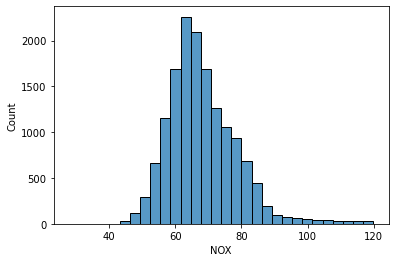

In [6]:
sns.histplot(df, x='NOX', bins=30)

<AxesSubplot:xlabel='CO', ylabel='Count'>

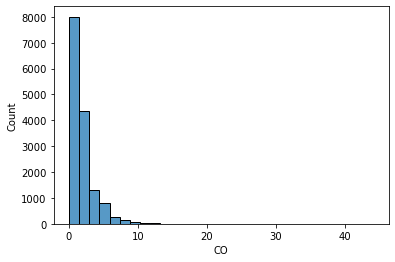

In [7]:
sns.histplot(df, x='CO', bins=30)

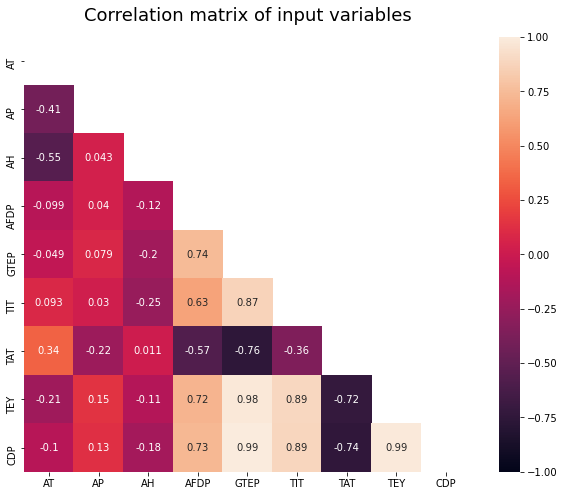

In [8]:

plt.figure(figsize=(10, 8))

mask = np.triu(np.ones_like(df.drop(columns=['CO','NOX']).corr()))

heatmap = sns.heatmap(df.drop(columns=['CO','NOX']).corr(), mask=mask, vmin=-1, vmax=1, annot=True)

heatmap.set_title('Correlation matrix of input variables', fontdict={'fontsize':18}, pad=16);

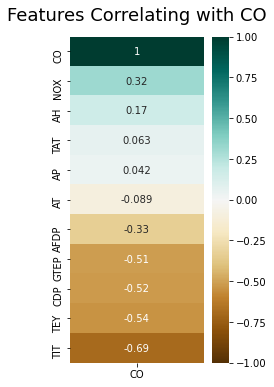

In [9]:
plt.figure(figsize=(3, 6))
heatmap = sns.heatmap(df.corr()[['CO']].sort_values(by='CO', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with CO', fontdict={'fontsize':18}, pad=16);

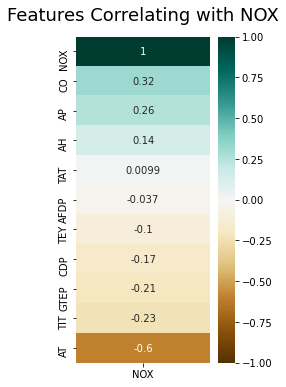

In [10]:
plt.figure(figsize=(3, 6))
heatmap = sns.heatmap(df.corr()[['NOX']].sort_values(by='NOX', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with NOX', fontdict={'fontsize':18}, pad=16);

Pairwise 

In [11]:
CO_list = []
NOX_list = []

for column in df.columns[:-2]:
    CO_list.append(df['CO'].corr(df[column]))
    NOX_list.append(df['NOX'].corr(df[column]))
corr_df = pd.DataFrame({'CO': CO_list, 'NOX': NOX_list},index=df.columns[:-2])    


cm = sns.light_palette("green", as_cmap=True)

corr_df.style.background_gradient(cmap='PiYG')

,CO,NOX
AT,-0.088588,-0.600006
AP,0.041614,0.256744
AH,0.165505,0.143061
AFDP,-0.334207,-0.037299
GTEP,-0.508259,-0.208496
TIT,-0.688272,-0.231636
TAT,0.063404,0.009888
TEY,-0.541751,-0.102631
CDP,-0.520783,-0.169103


# Prediction

In [12]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [13]:
X = df.drop(columns=['CO','NOX'], axis=1)

In [14]:
X = df[['TIT','TEY','CDP']]

y = df['CO']



X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.65,random_state=42
)

In [15]:
# https://towardsdatascience.com/using-gradient-boosting-for-time-series-prediction-tasks-600fac66a5fc

from xgboost import XGBRegressor
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)
model.fit(
    X_train, 
    y_train, 
    eval_metric="mape", 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-mape:0.65336	validation_1-mape:0.96567
[1]	validation_0-mape:0.63203	validation_1-mape:0.95911
[2]	validation_0-mape:0.64907	validation_1-mape:0.99267
[3]	validation_0-mape:0.66522	validation_1-mape:1.03152
[4]	validation_0-mape:0.67920	validation_1-mape:1.05297
[5]	validation_0-mape:0.69418	validation_1-mape:1.07619
[6]	validation_0-mape:0.70795	validation_1-mape:1.09934
[7]	validation_0-mape:0.72090	validation_1-mape:1.12561
[8]	validation_0-mape:0.73170	validation_1-mape:1.13073
[9]	validation_0-mape:0.73528	validation_1-mape:1.13268
[10]	validation_0-mape:0.73426	validation_1-mape:1.13238
[11]	validation_0-mape:0.73408	validation_1-mape:1.13509


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=8, min_child_weight=300, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [16]:
from sklearn.ensemble import GradientBoostingRegressor


reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

preds = reg.predict(X_test)

r2_score(y_test, preds)

0.6826807669511329

In [17]:
from sklearn.metrics import mean_absolute_error
# Mean absolute error
mae_test = mean_absolute_error(y_true=y_test, y_pred=preds)
mae_test

0.6040143496051434

In [18]:
#Defining MAPE function
def mape_fun(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [19]:
mape_fun(y_test,preds)

117.47867117649938

In [20]:
X = df[['AT']]

y = df['NOX']



X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.65,random_state=42
)

# https://towardsdatascience.com/using-gradient-boosting-for-time-series-prediction-tasks-600fac66a5fc

from xgboost import XGBRegressor
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)
model.fit(
    X_train, 
    y_train, 
    eval_metric="mape", 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-mape:0.69129	validation_1-mape:0.69156
[1]	validation_0-mape:0.48006	validation_1-mape:0.48055
[2]	validation_0-mape:0.33256	validation_1-mape:0.33329
[3]	validation_0-mape:0.22988	validation_1-mape:0.23055
[4]	validation_0-mape:0.16279	validation_1-mape:0.16315
[5]	validation_0-mape:0.12365	validation_1-mape:0.12358
[6]	validation_0-mape:0.10365	validation_1-mape:0.10331
[7]	validation_0-mape:0.09425	validation_1-mape:0.09372
[8]	validation_0-mape:0.08983	validation_1-mape:0.08922
[9]	validation_0-mape:0.08775	validation_1-mape:0.08732
[10]	validation_0-mape:0.08677	validation_1-mape:0.08656
[11]	validation_0-mape:0.08640	validation_1-mape:0.08629
[12]	validation_0-mape:0.08628	validation_1-mape:0.08627
[13]	validation_0-mape:0.08631	validation_1-mape:0.08633
[14]	validation_0-mape:0.08634	validation_1-mape:0.08642
[15]	validation_0-mape:0.08635	validation_1-mape:0.08650
[16]	validation_0-mape:0.08636	validation_1-mape:0.08652
[17]	validation_0-mape:0.08641	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=8, min_child_weight=300, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [21]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

preds = reg.predict(X_test)

r2_score(y_test, preds)

0.39952017949204055

In [22]:
mae_test = mean_absolute_error(y_true=y_test, y_pred=preds)
mae_test

5.929144331305397

In [23]:
mape_fun(y_test,preds)

8.664392555697313